<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230610_finetuning_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segment_anything segment_geospatial opencv-python pycocotools matplotlib onnxruntime onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 24.1 MB/s eta 0:00:00


## Step 1: Data Preparation

### Load Sample Training data from Disk

192it [01:11,  2.70it/s]
48it [00:30,  1.55it/s]


### Format data using SAM preprocess functions
* use utils.transform.ResizeLongestSide to resize the image
* convert the image to a pytorch tensor
* use SAM preprocess functions

'0'

## Step 2: Getting SAM module instance and prepare it for **finetuning**

## Step 3: Starting Finetuning using torch or lightning



## Step 4: Evaluation


Most of the following code is from encord.com:

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from samgeo import download_checkpoint

#model_type = 'vit_h'
#checkpoint = 'sam_vit_h_4b8939.pth'
#checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
device = 'cuda:0'
# device = 'cpu:0'

# credits: Cached downloading of checkpoint was taken from samgeo project

# Download the checkpoint if it does not exist
CACHE_PATH = os.environ.get(
    "TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints")
)

if not os.path.exists(checkpoint):
    basename = os.path.basename(checkpoint)
    checkpoint = os.path.join(CACHE_PATH, basename)
    if not os.path.exists(checkpoint):
        print(f"Checkpoint {checkpoint} does not exist.")
        download_checkpoint(url=checkpoint_url, output=checkpoint)

Checkpoint /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth
100%|██████████| 375M/375M [00:02<00:00, 146MB/s]


In [3]:
!ls -al ~/.cache/torch/hub/checkpoints/*

-rw-r--r-- 1 root root 375042383 Jun 12 13:41 /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth


In [91]:
from segment_anything import SamPredictor, sam_model_registry

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


We convert the input images into a format SAM's internal functions expect.

In [92]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide
import cv2
import random
from typing import List, Dict
import numpy as np

transform = ResizeLongestSide(sam_model.image_encoder.img_size)

def preprocess_input_image(image_rgb):
  input_image = transform.apply_image(image_rgb)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image_rgb.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  return input_image, input_size, original_image_size



In [93]:
# from segment_anything.utils.amg import box_xyxy_to_xywh
from pathlib import Path
import numpy as np
from typing import List, Dict
from tqdm import tqdm
from skimage.io import imread

dataset_folder = Path('drive/MyDrive/sam-bridges/dataset')

def box_xywh2xyxy(box: np.ndarray) -> np.ndarray:
  """Expects a numpy array shape Bx4"""

  if len(box)==0:
    return box

  box = box.copy()
  box[..., 2] += box[..., 0]  # Width to x2
  box[..., 3] += box[..., 1]  # Height to y2
  return box

def load_dataset(dataset_path: Path) -> List[Dict] :
  dataset = []
  for datapoint_pth in tqdm(dataset_path.glob('*')):
    sat = imread(datapoint_pth / 'sat.png')
    # TODO: Generate image embeddings already here

    box_xywh = np.load(datapoint_pth / 'bboxes.npy')  # loaded in xywh format
    box_xyxy = box_xywh2xyxy(box_xywh)
    dataset.append({
        'tile_id': datapoint_pth.name,
        'bboxes': box_xyxy,
        'bg_points': np.load(datapoint_pth / 'bg_points.npy'),
        'fg_points': np.load(datapoint_pth / 'fg_points.npy'),
        'mask': imread(datapoint_pth / 'mask.png')//255,
        'sat': sat,
        'input_size': input_size,
        'original_image_size': original_image_size
    })
  return dataset

train_dataset = load_dataset(dataset_folder / "train")
test_dataset = load_dataset(dataset_folder / "test")

192it [00:02, 72.87it/s]
48it [00:00, 71.68it/s]


In [94]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
#keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop. 

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [95]:
# Preprocess image embeddings

def preprocess_image_embeddings(dataset):
  for datapoint in tqdm(dataset):
    input_image, input_size, original_image_size = preprocess_input_image(datapoint['sat'])

    input_image = input_image.to(device)
    with torch.no_grad():
      datapoint['image_embedding'] = sam_model.image_encoder(input_image)

preprocess_image_embeddings(train_dataset)
preprocess_image_embeddings(test_dataset)

100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


In [137]:
from statistics import mean

from tqdm import tqdm, trange
from torch.nn.functional import threshold, normalize
import random

# this is only for testing to get reproducibility. Can be removed later
train_dataset = train_dataset_original.copy()
#train_dataset_original = train_dataset.copy()

random.seed(57)

num_epochs = 10
losses = []

for epoch in trange(num_epochs):
  random.shuffle(train_dataset)
  epoch_losses = []
  # Just train on the first 20 examples
  for train_dp in train_dataset[:100]:
    input_size = train_dp['input_size']
    original_image_size = train_dp['original_image_size']
    
    gt_mask = train_dp['mask']
    # No grad here as we don't want to optimise the encoders
    # TODO: Pre-compute the image embeddings already when loading the dataset
    with torch.no_grad():
      if "image_embedding" not in train_dp:
        input_image = train_dp['input_image'].to(device)
        image_embedding = sam_model.image_encoder(input_image)
        train_dp['image_embedding'] = image_embedding
      
      prompt_boxes = train_dp['bboxes']
      if len(prompt_boxes)==0:
        boxes_torch = None
      else:
        if len(prompt_boxes) ==1:
          selected_box = prompt_boxes
        else:
          # Currently, segment-anything only accepts a single input box
          selected_box = prompt_boxes[random.randint(0, len(prompt_boxes)-1)]
          gt_mask_new = np.zeros(gt_mask.shape)
          x1,y1,x2,y2 = selected_box
          gt_mask_new[y1:y2,x1:x2] = gt_mask[y1:y2,x1:x2]
          gt_mask = gt_mask_new

        boxes = transform.apply_boxes(selected_box, original_image_size)
        boxes_torch = torch.as_tensor(boxes, dtype=torch.float, device=device)
        boxes_torch = boxes_torch[None, :]


      # TODO: Add points as input
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=boxes_torch,
          masks=None,
      )

    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=train_dp['image_embedding'],
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(gt_mask, (1, 1, gt_mask.shape[0], gt_mask.shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
    
    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

 10%|█         | 1/10 [00:02<00:26,  2.97s/it]

EPOCH: 0
Mean loss: 0.028941294401884077


 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

EPOCH: 1
Mean loss: 0.025695037841796876


 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

EPOCH: 2
Mean loss: 0.014995880126953125


 40%|████      | 4/10 [00:10<00:14,  2.44s/it]

EPOCH: 3
Mean loss: 0.03589182540774345


 50%|█████     | 5/10 [00:12<00:11,  2.30s/it]

EPOCH: 4
Mean loss: 0.031062774658203125


 60%|██████    | 6/10 [00:14<00:08,  2.21s/it]

EPOCH: 5
Mean loss: 0.04314208984375


 70%|███████   | 7/10 [00:16<00:06,  2.13s/it]

EPOCH: 6
Mean loss: 0.029318084716796877


 80%|████████  | 8/10 [00:18<00:04,  2.08s/it]

EPOCH: 7
Mean loss: 0.03683517456054688


 90%|█████████ | 9/10 [00:21<00:02,  2.29s/it]

EPOCH: 8
Mean loss: 0.02785369873046875


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]

EPOCH: 9
Mean loss: 0.037733154296875


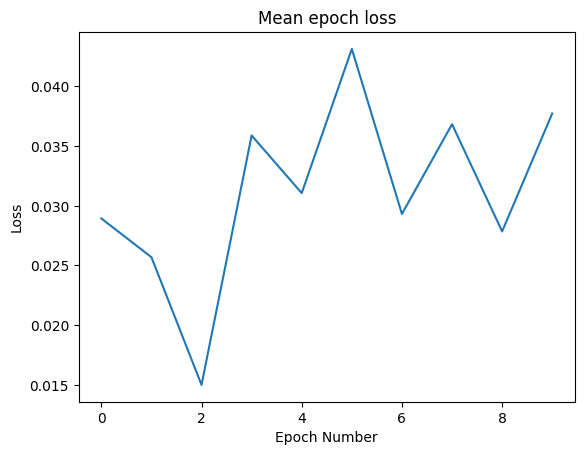

In [138]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [139]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [140]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [141]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
tile_id = 206
test_datapoint = [d for d in test_dataset if d['tile_id']=="206"][0]

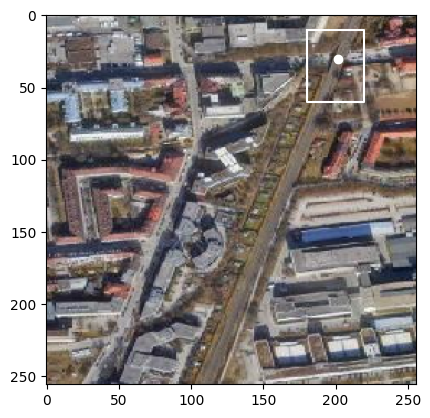

In [149]:
debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 180, 10, 40, 50
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 202, 30
plt.plot(point_x, point_y, color='white', marker = 'o')

In [143]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
tile_id = 206
test_datapoint = [d for d in test_dataset if d['tile_id']=='206'][0]

predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])


We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

In [144]:
test_datapoint['sat'].shape

(256, 256, 3)

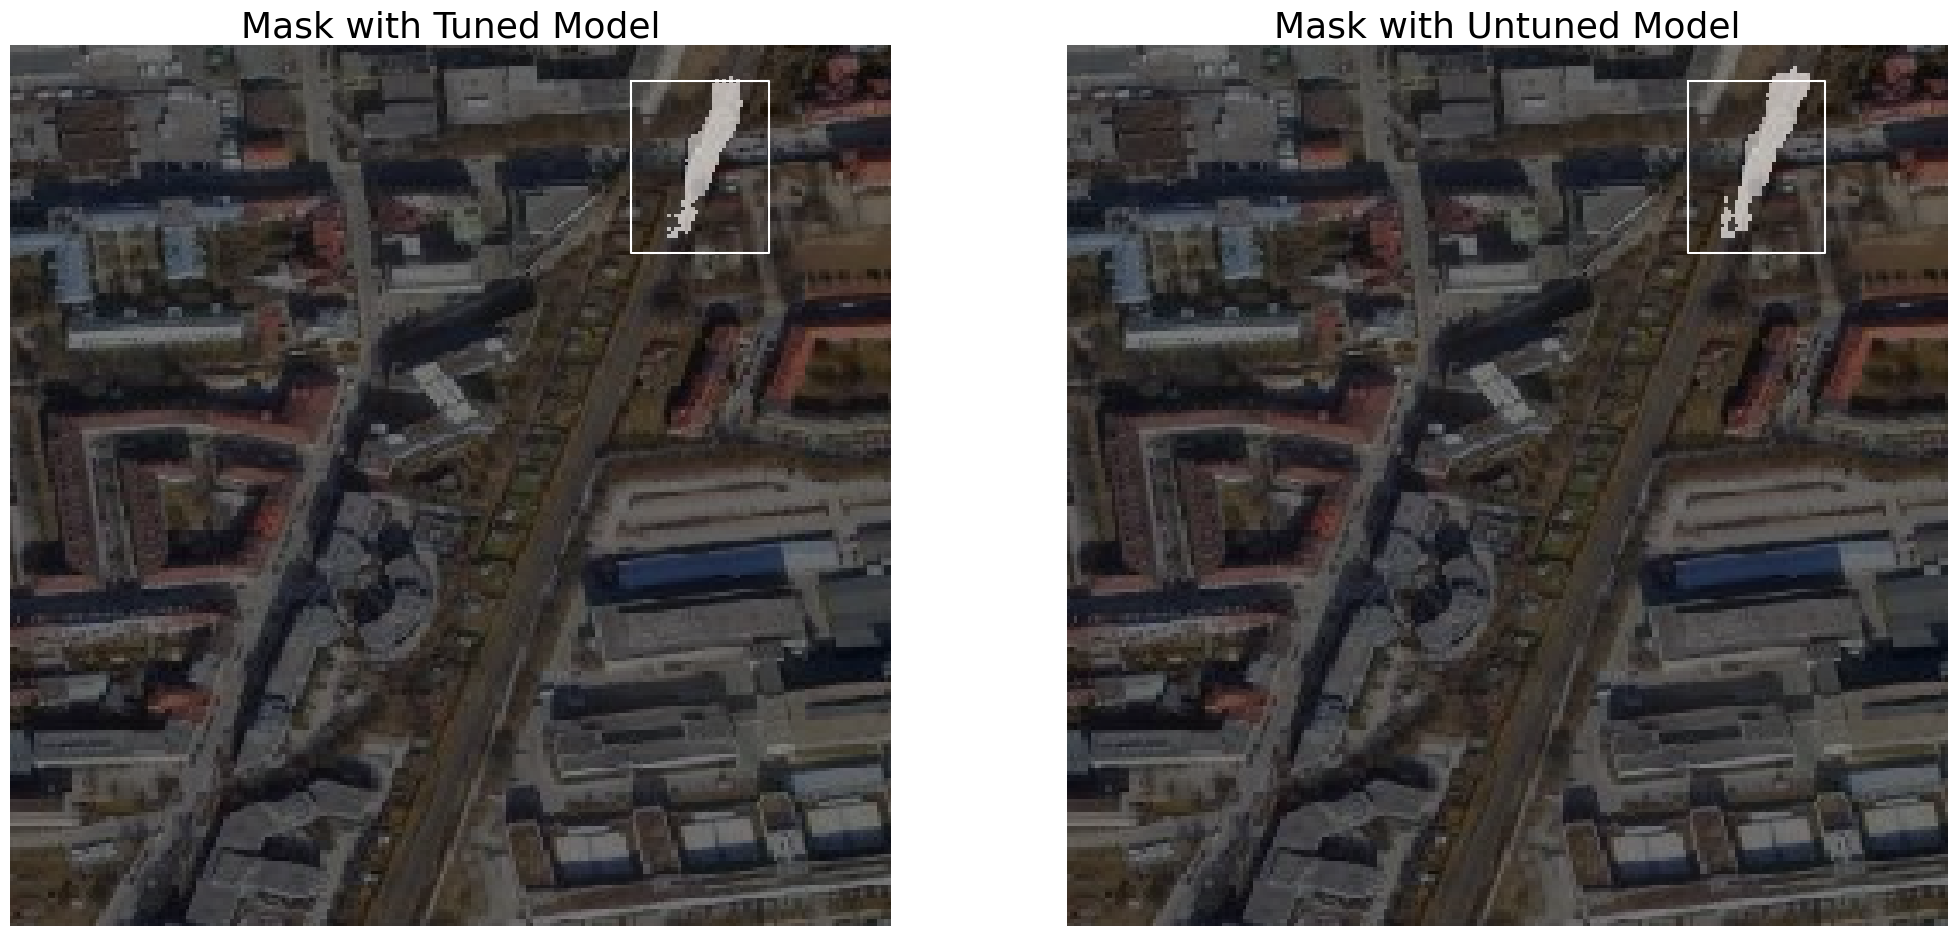

In [151]:
input_bbox = np.array(input_bbox)

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)


%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[0].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
#show_mask(masks_tuned, axs[0])
#show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[1].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')

#axs[1].imshow(test_datapoint['sat'])
#show_mask(masks_orig, axs[1])
#show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  

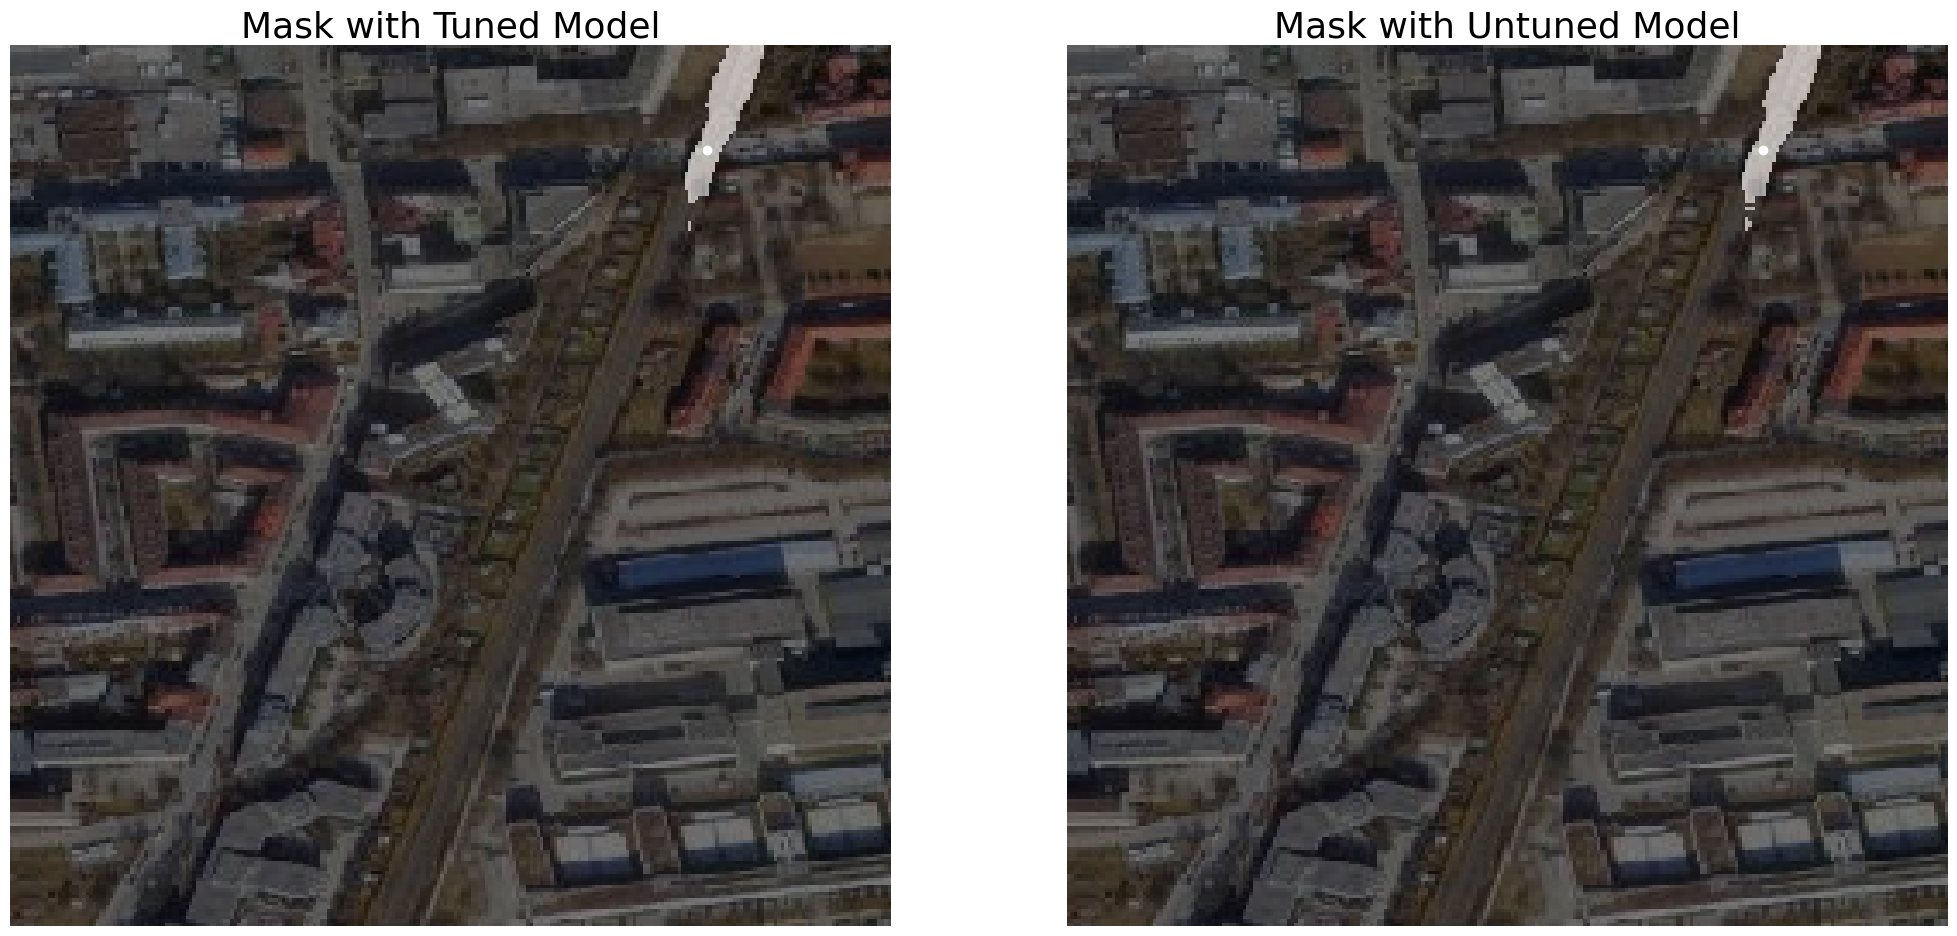

In [153]:
input_points = np.array([[point_x, point_y]])
point_labels = np.array([1])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
)

%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))

axs[0].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[0].plot(point_x, point_y, color='white', marker = 'o')
#show_mask(masks_tuned, axs[0])
#show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[1].plot(point_x, point_y, color='white', marker = 'o')

#axs[1].imshow(test_datapoint['sat'])
#show_mask(masks_orig, axs[1])
#show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  

In [173]:
masks_orig, confidences_orig, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True
)

masks_tuned, confidences_tuned, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True
)

assert len(confidences_tuned) == len(confidences_orig)

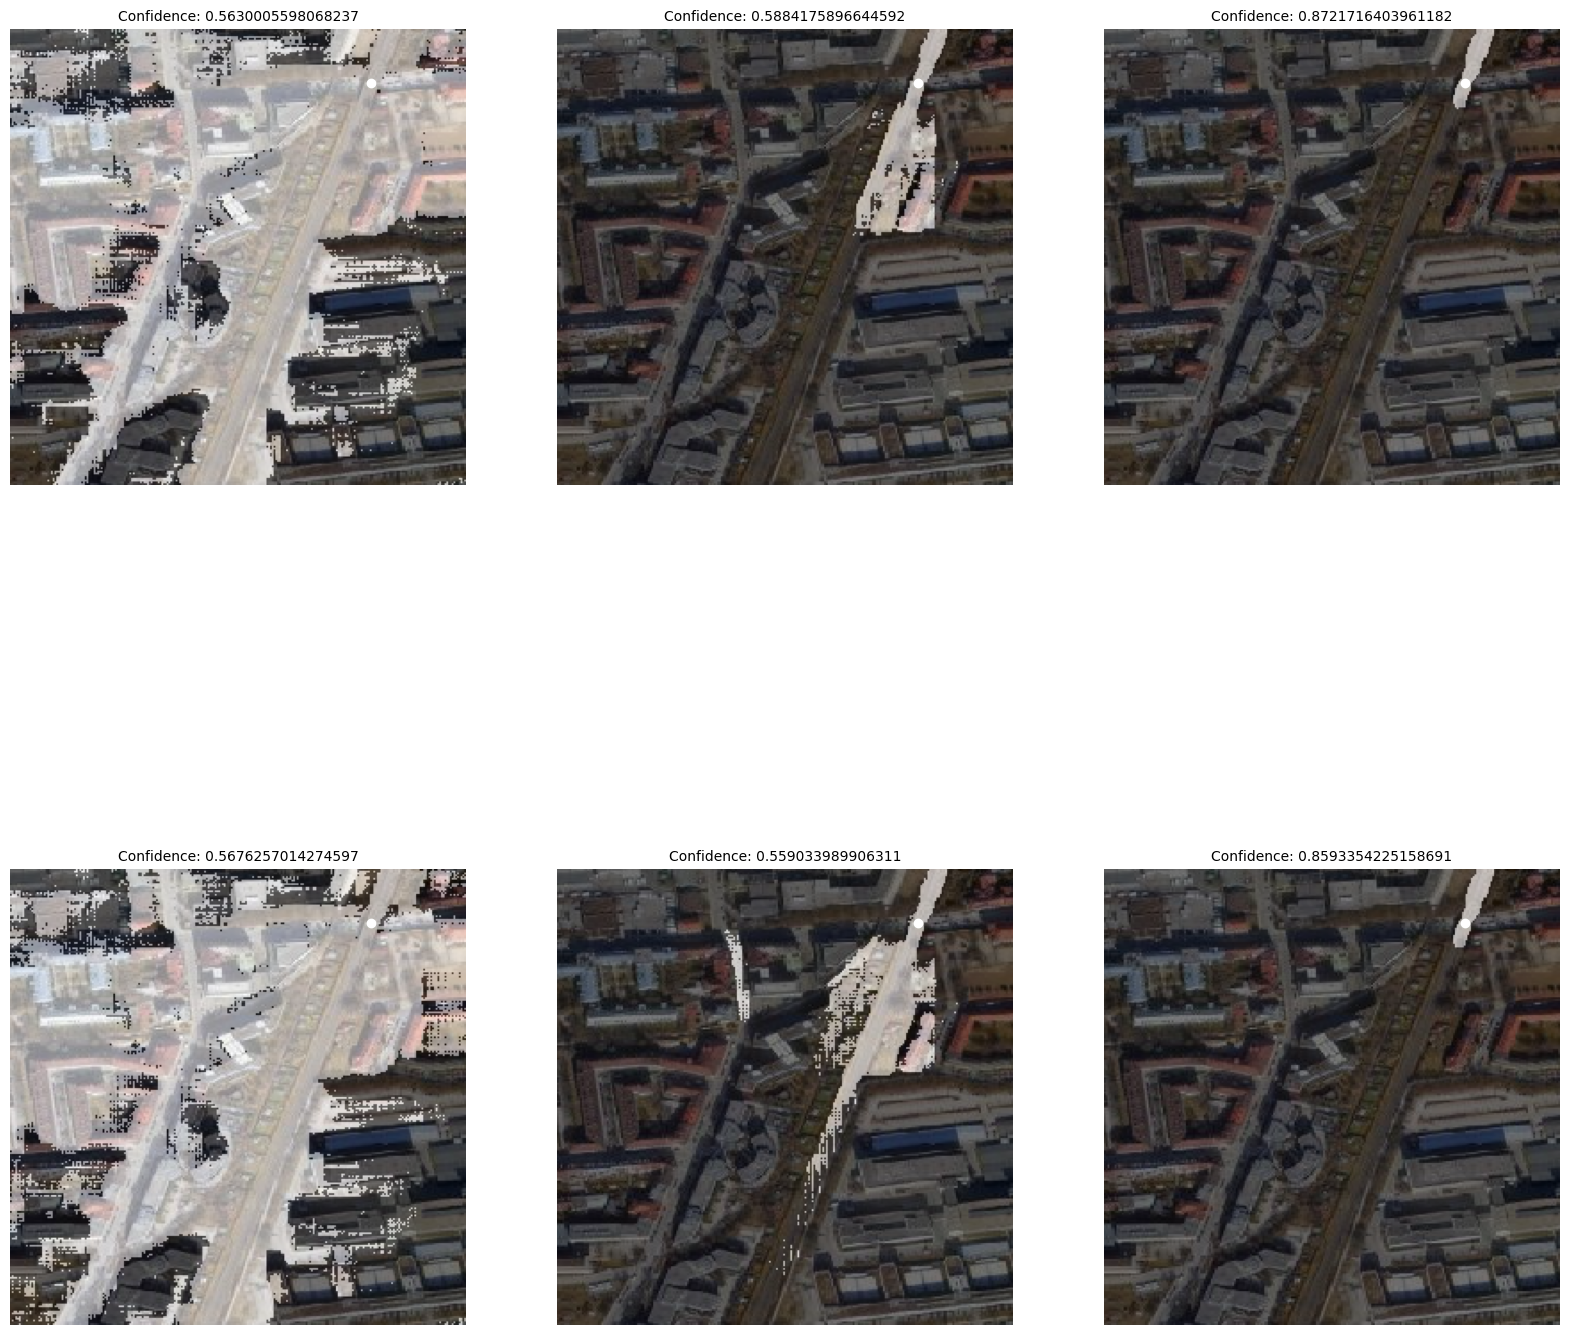

In [176]:
%matplotlib inline 
_, axs = plt.subplots(2, max(len(confidences_orig), len(confidences_tuned)), figsize=(20, 20))

for ax_id in range(len(confidences_orig)):
  axs[0, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  #axs[ax_id].imshow(masks_orig[ax_id,:,:])

  axs[0, ax_id].plot(point_x, point_y, color='white', marker = 'o')

  axs[0, ax_id].set_title(f'Confidence: {confidences_orig[ax_id]}', fontsize=10)
  axs[0, ax_id].axis('off')

for ax_id in range(len(confidences_tuned)):
  axs[1, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  #axs[ax_id].imshow(masks_orig[ax_id,:,:])

  axs[1, ax_id].plot(point_x, point_y, color='white', marker = 'o')

  axs[1, ax_id].set_title(f'Confidence: {confidences_tuned[ax_id]}', fontsize=10)
  axs[1, ax_id].axis('off')

In [ ]:
f